In [1]:
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns 
import geopandas as gpd 
import matplotlib.pyplot as plt 
from epiweeks import Week 
import matplotlib.gridspec as gridspec

In [2]:
from utils import richards, get_data_pars, get_richards_pars, plot_curve, plot_dengue_vs_chik, scatter_ep_dur_R0 

## Code to generate Figure 2

In [3]:
state = 'RJ'
agravo = 'dengue'

df_state = pd.read_parquet(f'./data/{state}_{agravo}.parquet')

df_state.sort_index().tail()

,SE,casos_est,casos_est_min,casos_est_max,casos,municipio_geocodigo,p_rt1,p_inc100k,Localidade_id,nivel,...,nivel_inc,umidmed,umidmin,tempmed,tempmax,casprov,casprov_est,casprov_est_min,casprov_est_max,casconf
data_iniSE,,,,,,,,,,,,,,,,,,,,,
2024-05-26,202422,0.0,0,0.0,0,3303203,0.000000,0.000000,0,1,...,0,81.804990,80.489304,20.742857,21.142857,None,None,None,None,None
2024-05-26,202422,1.0,0,10.0,0,3305133,0.146637,14.144272,0,1,...,0,84.854805,84.854805,21.714286,21.714286,None,None,None,None,None
2024-05-26,202422,5.0,0,40.0,0,3300605,0.059946,13.967651,0,1,...,1,84.854805,84.854805,21.714286,21.714286,None,None,None,None,None
2024-05-26,202422,8.0,1,52.0,0,3304128,0.198803,63.261110,0,1,...,1,64.303165,52.923726,18.843428,22.080000,None,None,None,None,None
2024-05-26,202422,15.0,2,67.0,0,3301702,0.000048,1.916201,0,1,...,1,81.804990,80.489304,20.742857,21.142857,None,None,None,None,None


Volta do modelo: 

In [4]:
# df_state, pars = get_data_pars('SC', 'dengue')
df_state, pars = get_data_pars('RJ', 'dengue')

city_geocode = 3304557

pars = pars.loc[pars.year !=2024]

p = pars.loc[pars.geocode == city_geocode]
p = p.sort_values(by = 'year')

p = p.loc[~p.year.isin([2014, 2015, 2017, 2020, 2022])]

p.head()

,geocode,muni_name,year,peak_week,beta,gamma,R0,total_cases,alpha,sum_res,aic,bic,t_ini,t_end,ep_ini,ep_pw,ep_end,ep_dur,mape,mae
150,3304557,Rio De Janeiro,2011,22.352770,0.573921,0.300086,1.912522,76221.948779,0.477130,0.480776,1073.468408,1081.273383,8,33,201101,201115,201126,25,0.064923,0.000114
151,3304557,Rio De Janeiro,2012,23.626359,0.558857,0.329981,1.693601,190607.697247,0.409542,0.319594,1139.409542,1147.214517,6,36,201151,201217,201229,30,0.084250,0.000185
152,3304557,Rio De Janeiro,2013,20.288201,0.573818,0.300064,1.912321,71909.713727,0.477075,0.428476,985.355094,993.160069,6,31,201251,201313,201324,25,0.068580,0.000094
142,3304557,Rio De Janeiro,2016,21.093757,0.551740,0.329983,1.672024,33264.760255,0.401922,0.811541,983.993871,991.798846,3,34,201548,201614,201627,31,0.104723,0.000081
144,3304557,Rio De Janeiro,2018,26.496545,0.423694,0.300038,1.412135,6856.723039,0.291853,0.698609,611.160387,618.965362,1,46,201746,201819,201839,45,0.160778,0.000014


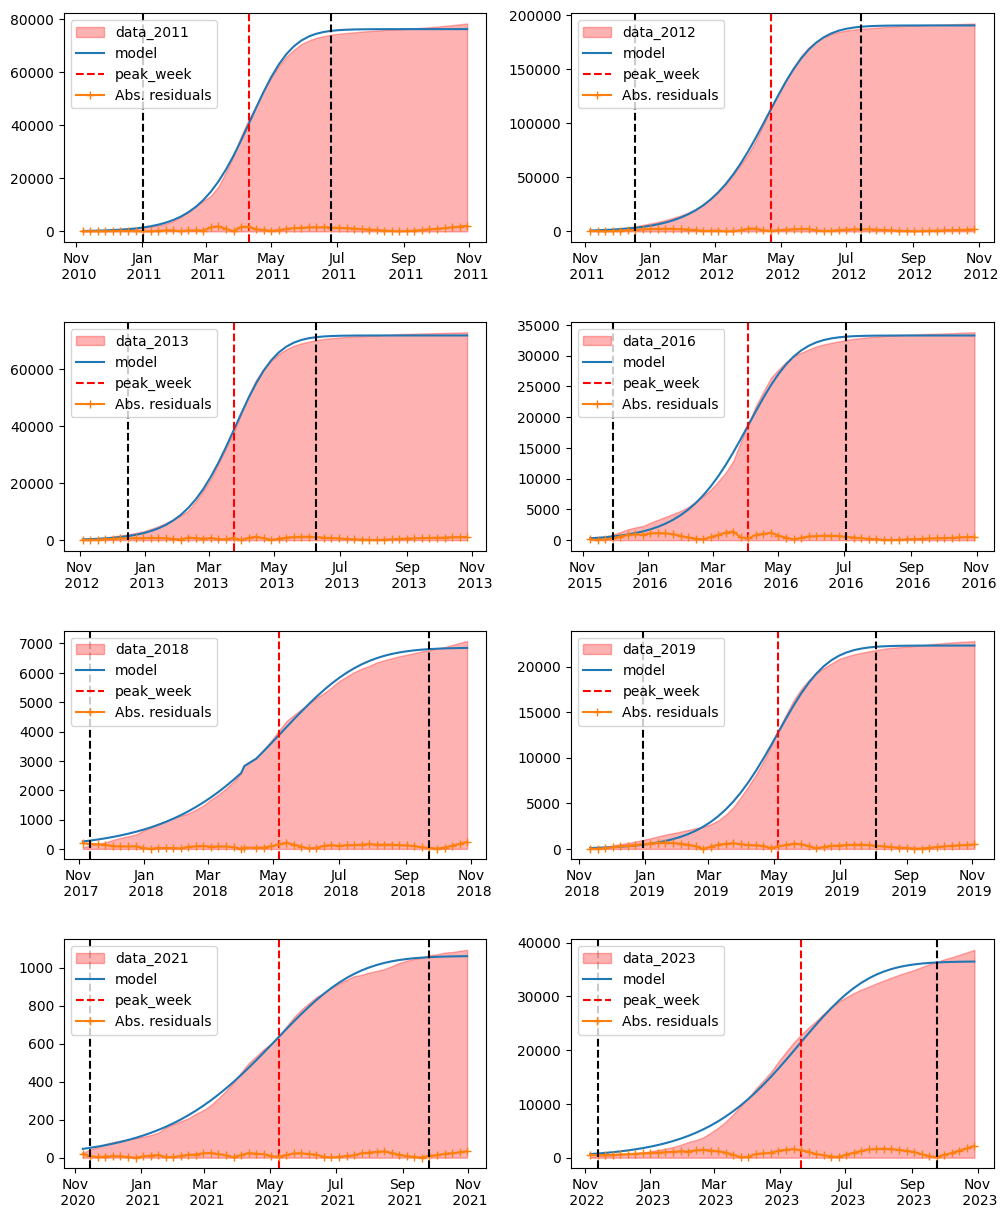

In [5]:
_,ax = plt.subplots(4,2, figsize = (12, 15))

ax = ax.ravel()

for year, ax in zip(p.year, ax): 
    
    p_ = p.loc[p.year == year].to_dict(orient = 'records')[0]
    plot_curve(ax, df_state,  p_)

    ax.axvline(Week.fromstring(str(p_['ep_ini'])).startdate(), color = 'black', ls = '--')
    ax.axvline(Week.fromstring(str(p_['ep_end'])).startdate(), color = 'black', ls = '--')


plt.subplots_adjust(hspace = 0.35)

plt.savefig('./figures/start_end_rio.png', dpi = 300, bbox_inches = 'tight')

## Code to generate Maps

In [6]:
def get_muni_shape(): 
    '''
    Function to get the shape file of the cities 
    '''
    brmap = gpd.read_file('./data/muni_br.gpkg', driver='GPKG')


    brmap['region']= np.nan

    brmap.loc[brmap.abbrev_state.isin(['SC', 'PR', 'RS']), 'region'] = 'South'

    brmap.loc[brmap.abbrev_state.isin(['SP', 'MG', 'RJ', 'ES']), 'region'] = 'Southeast'

    brmap.loc[brmap.abbrev_state.isin(['BA', 'CE', 'PE', 'PB', 'PI', 'RN', 'MA', 'AL', 'SE']), 'region'] = 'North East'

    brmap.loc[brmap.abbrev_state.isin(['DF', 'MT', 'MS', 'GO']), 'region'] = 'Midwest'

    brmap.loc[brmap.abbrev_state.isin(['RO', 'AC', 'AM', 'RR', 'PA', 'AP', 'TO']), 'region'] = 'North'

    return brmap


def agg_by_muni(pars_end_new, shape_muni): 
    '''
    Function to aggregate the parameters by cities
    '''
    
    pars_end_new = pars_end_new.set_index(['geocode']).groupby([pd.Grouper(level='geocode')]).median()
    
    df = shape_muni[['geometry']].merge(pars_end_new, left_index = True, right_index = True)
    
    for col in ['ep_ini', 'ep_end', 'peak_week']: 
        
        df[col] = round(df[col], 0).astype(int)
        
        df.loc[df[col] <= 7, col] = df.loc[df[col] <= 7][col] + 45
        
        df.loc[df[col] > 7, col] = df.loc[df[col] > 7][col] - 7
    return df 
    

    
def get_pars_all(agravo, flag = 'nov'): 
    '''
    Get the parameters estimated by all the states
    '''
    
    estados = {'RJ': 'Rio de Janeiro', 'ES': 'Espírito Santo', 'PR': 'Paraná', 'CE': 'Ceará',
               'MA': 'Maranhão', 'MG': 'Minas Gerais', 'SC': 'Santa Catarina', 'PE': 'Pernambuco', 
               'PB': 'Paraíba', 'RN': 'Rio Grande do Norte', 'PI': 'Piauí', 'AL': 'Alagoas',
               'SE': 'Sergipe', 'SP': 'São Paulo', 'RS': 'Rio Grande do Sul','PA': 'Pará',
               'AP': 'Amapá', 'RR': 'Roraima', 'RO': 'Rondônia', 'AM': 'Amazonas', 'AC': 'Acre',
               'MT': 'Mato Grosso', 'MS': 'Mato Grosso do Sul', 'GO': 'Goiás', 'TO': 'Tocantins',
               'DF': 'Distrito Federal', 'BA': 'Bahia'
               }


    pars_end = pd.DataFrame()
    for state in tqdm.tqdm(estados):

        # pars = pd.read_csv(f'./params/pars_{state}_{agravo}_old.csv.gz', index_col = 'Unnamed: 0')
        pars = pd.read_csv(f'./params/pars_{state}_{agravo}_{flag}.csv.gz', index_col = 'Unnamed: 0')
        
        if pars.shape[0] == 0: 
            print(state)

        else:
            thr = np.percentile(pars.sum_res, q = 90)

            pars = pars.loc[pars.sum_res <= thr]

        pars['state'] = state

        pars_end = pd.concat([pars_end, pars])


    pars_end['region']= np.nan

    pars_end.loc[pars_end.state.isin(['SC', 'PR', 'RS']), 'region'] = 'South'

    pars_end.loc[pars_end.state.isin(['SP', 'MG', 'RJ', 'ES']), 'region'] = 'Southeast'

    pars_end.loc[pars_end.state.isin(['BA', 'CE', 'PE', 'PB', 'PI', 'RN', 'MA', 'AL', 'SE']), 'region'] = 'North East'

    pars_end.loc[pars_end.state.isin(['DF', 'MT', 'MS', 'GO']), 'region'] = 'Midwest'

    pars_end.loc[pars_end.state.isin(['RO', 'AC', 'AM', 'RR', 'PA', 'AP', 'TO']), 'region'] = 'North'
    
    pars_end.ep_dur = pars_end.ep_dur.astype(int)
    
    pars_end['week_ini'] = [ int(str(x)[-2:]) for x in pars_end.ep_ini] 

    pars_end = pars_end.loc[pars_end.year <= 2023]

    pars_end['ep_ini'] = (pars_end['ep_ini'].astype(str).str[-2:]).astype(int)
    pars_end['ep_end'] = (pars_end['ep_end'].astype(str).str[-2:]).astype(int)

    return pars_end


In [7]:
pars_end = get_pars_all('dengue', 'nov')

pars_end_c =  get_pars_all('chik', 'nov')

100%|██████████████████████████████████████████| 27/27 [00:00<00:00, 242.21it/s]
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_24691/1221439822.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'South' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pars_end.loc[pars_end.state.isin(['SC', 'PR', 'RS']), 'region'] = 'South'
100%|██████████████████████████████████████████| 27/27 [00:00<00:00, 646.32it/s]
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_24691/1221439822.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'South' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pars_end.loc[pars_end.state.isin(['SC', 'PR', 'RS']), 'region'] = 'South'


In [8]:
df_muni =  get_muni_shape() 

df_muni.set_index('code_muni', inplace = True)

df_muni.head()

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_24691/1221439822.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'South' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  brmap.loc[brmap.abbrev_state.isin(['SC', 'PR', 'RS']), 'region'] = 'South'


,name_muni,code_state,abbrev_state,geometry,region
code_muni,,,,,
1100015.0,Alta Floresta D'oeste,11,RO,"POLYGON ((-62.23224 -11.90804, -62.20670 -11.8...",North
1100023.0,Ariquemes,11,RO,"POLYGON ((-63.57327 -9.78326, -63.57016 -9.773...",North
1100031.0,Cabixi,11,RO,"POLYGON ((-60.71834 -13.39058, -60.70904 -13.3...",North
1100049.0,Cacoal,11,RO,"POLYGON ((-61.27873 -11.50596, -61.28097 -11.5...",North
1100056.0,Cerejeiras,11,RO,"POLYGON ((-61.41347 -13.23417, -61.42603 -13.2...",North


### Figure 3

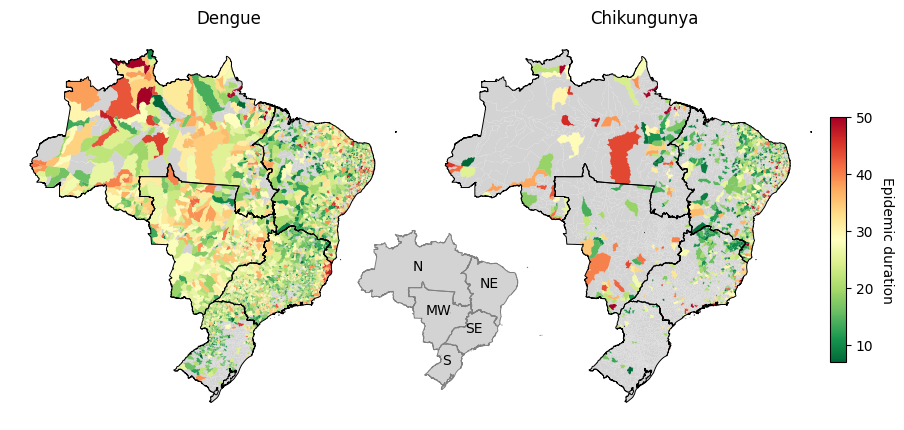

In [9]:
plot_dengue_vs_chik(agg_by_muni(pars_end[['geocode', 'peak_week', 'ep_end', 'ep_dur', 'ep_ini']], df_muni),
                    agg_by_muni(pars_end_c[['geocode', 'peak_week', 'ep_end', 'ep_dur', 'ep_ini']], df_muni),
                    df_muni, column = 'ep_dur',
                    title = '',
                    title_colorbar = 'Epidemic duration',
                    save = True)

### Figure 4

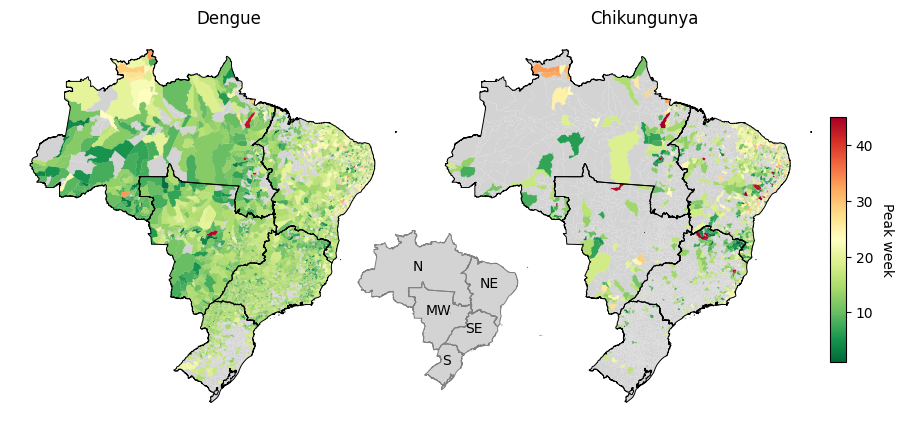

In [10]:
plot_dengue_vs_chik(agg_by_muni(pars_end[['geocode', 'peak_week', 'ep_end', 'ep_dur', 'ep_ini']], df_muni),
                    agg_by_muni(pars_end_c[['geocode', 'peak_week', 'ep_end', 'ep_dur', 'ep_ini']], df_muni),
                    df_muni, column = 'peak_week',
                    title = '',
                    title_colorbar = 'Peak week',
                    save = True)

### Figure 1 map suplementar:

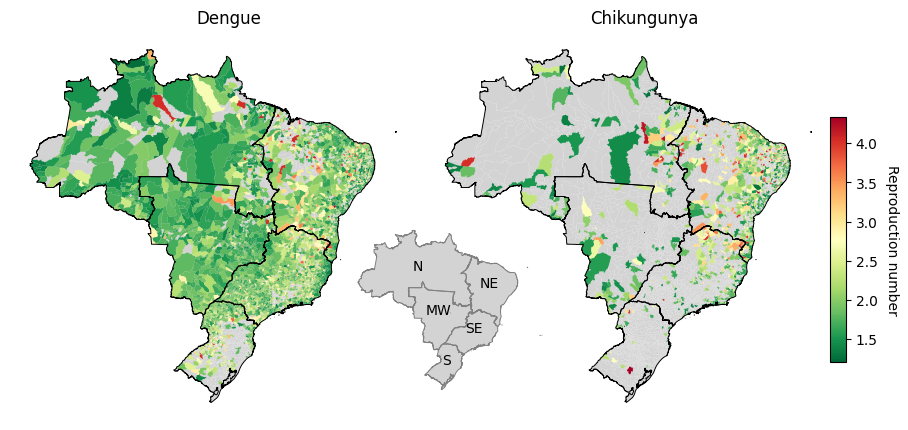

In [11]:
plot_dengue_vs_chik(agg_by_muni(pars_end[['geocode', 'peak_week', 'R0', 'ep_end', 'ep_dur', 'ep_ini']], df_muni),
                    agg_by_muni(pars_end_c[['geocode', 'peak_week', 'R0', 'ep_end', 'ep_dur', 'ep_ini']], df_muni),
                    df_muni, column = 'R0',
                    title = '',
                    title_colorbar = 'Reproduction number',
                    save = True)


### Figure 5

In [12]:
df_ = pd.read_csv('./data/time_series_BR.csv.gz')

df_['data_iniSE'] = pd.to_datetime(df_['data_iniSE'])

df_.set_index('data_iniSE', inplace = True)


df_.head()

,casos
data_iniSE,
2010-01-03,25456
2010-01-10,29833
2010-01-17,32969
2010-01-24,37392
2010-01-31,42084


In [13]:
code_to_state = {33: 'RJ', 32: 'ES', 41: 'PR', 23: 'CE', 21: 'MA',
 31: 'MG', 42: 'SC', 26: 'PE', 25: 'PB', 24: 'RN', 22: 'PI', 27: 'AL',
 28: 'SE', 35: 'SP', 43: 'RS', 15: 'PA', 16: 'AP', 14: 'RR',  11: 'RO',
 13: 'AM', 12: 'AC', 51: 'MT', 50: 'MS', 52: 'GO', 17: 'TO', 53: 'DF',
 29: 'BA'}

In [14]:
pars_ = pd.DataFrame()

for state in code_to_state.values():
    pars = pd.read_csv(f'./params/pars_{state}_dengue_nov.csv.gz', index_col = 'Unnamed: 0')
    pars['state'] = state
    pars_ = pd.concat([pars_, pars])

pars_.head()

,geocode,muni_name,year,peak_week,beta,gamma,R0,total_cases,alpha,sum_res,...,bic,t_ini,t_end,ep_ini,ep_pw,ep_end,ep_dur,mape,mae,state
0,3302403,Macaé,2016,19.537016,0.432149,0.300168,1.439690,1824.313203,0.305406,1.568059,...,499.590409,1,38,201546,201613,201631,37,2.987346e-01,0.000240,RJ
1,3302403,Macaé,2017,18.634610,0.434912,0.300134,1.449062,181.884998,0.309899,1.288028,...,9.736168,1,37,201646,201712,201730,36,9.349365e-02,0.000019,RJ
2,3302403,Macaé,2018,36.303712,0.474765,0.329871,1.439247,90.694290,0.305192,1.234990,...,-161.052911,9,51,201802,201829,201844,42,8.763808e+13,0.000008,RJ
3,3302403,Macaé,2019,27.224857,0.416788,0.300016,1.389220,226.729610,0.280172,1.742085,...,94.286613,1,48,201847,201921,201942,47,5.340820e-01,0.000030,RJ
4,3302403,Macaé,2020,39.404992,0.420150,0.327101,1.284465,70.754526,0.221466,3.242491,...,-60.337259,1,51,201947,202033,202045,50,2.832890e-01,0.000014,RJ


In [15]:
def load_enso():
    '''
    Load enso indicator 
    '''
    enso = pd.read_csv('./data/ENSO_meiv2.csv', index_col=0)
    #enso.set_index('YEAR', inplace=True)
    index = pd.date_range(start='1979-01-01', end='2023-12-31',freq='M')
    enso = enso.T.melt()
    enso['date'] = index#

    enso.set_index('date', inplace=True)

    enso = enso.resample('M').mean()

    enso['YEAR'] = enso.index.year

    enso['month'] = enso.index.month

    #enso['quarter'] = enso['quarter'].replace({3:1, 6:2, 9:3, 12:4})

    enso.columns = enso.columns.str.lower() 


    enso = enso.loc[(enso.index >= pd.to_datetime('2010-11-01')) & (enso.index <= pd.to_datetime('2023-11-01'))]

    return enso

enso = load_enso()

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_24691/2367303957.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range(start='1979-01-01', end='2023-12-31',freq='M')
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_24691/2367303957.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  enso = enso.resample('M').mean()


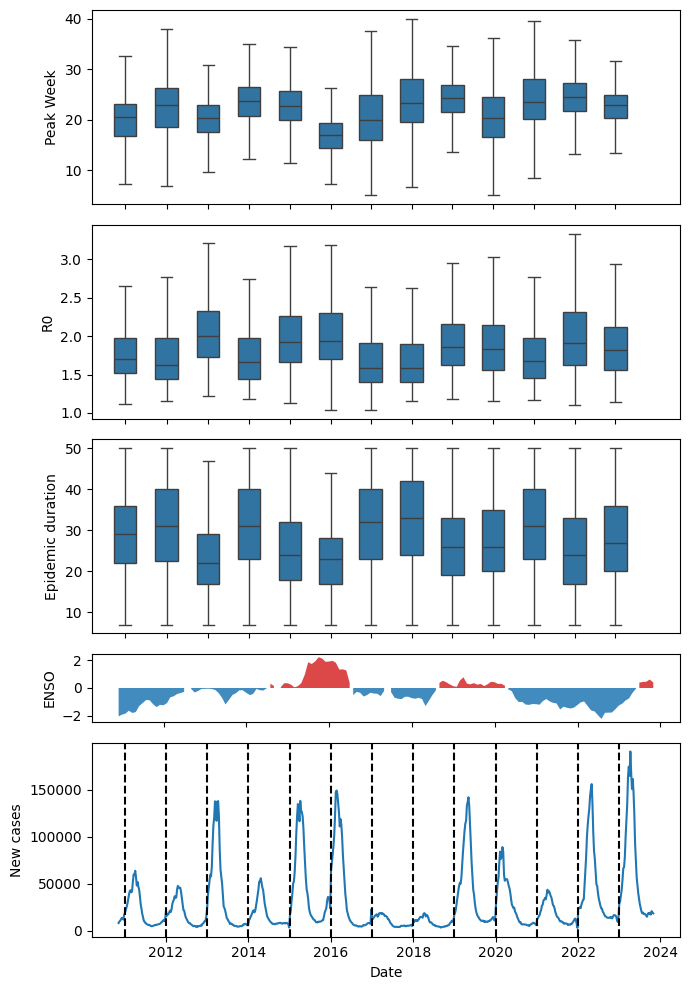

In [16]:
fig = plt.figure(figsize=(7, 10))

# Create a GridSpec with 3 rows and 1 column
gs = gridspec.GridSpec(5, 1, height_ratios=[1, 1, 1, 0.35, 1])

positions = [0.23, 1.15, 2.07, 2.97, 3.88, 4.78, 5.66, 6.57,7.47,8.37,9.27,10.17, 11.07]

x_labels = ['2011','2012','2013','2014','2015','2016','2017','2018','2019',
                      '2020', '2021','2022','2023']

ax1 = fig.add_subplot(gs[0])

sns.boxplot(data=pars_, x='year', y='peak_week', ax=ax1, width=0.5, positions= positions, showfliers = False)
ax1.set_xlabel('')
ax1.set_ylabel('Peak Week')
ax1.set_xticks(positions)
#ax[0].set_xticklabels(x_labels)
ax1.set_xticklabels([])

ax2 = fig.add_subplot(gs[1])
sns.boxplot(data=pars_, x='year', y='R0', ax=ax2,width=0.5, positions= positions, showfliers = False)
ax2.set_xlabel('')
ax2.set_ylabel('R0')
ax2.set_xticks(positions)
ax2.set_xticklabels([])

ax3 = fig.add_subplot(gs[2])
sns.boxplot(data=pars_, x='year', y='ep_dur', ax=ax3,width=0.5, positions= positions, showfliers = False)
ax3.set_xlabel('')
ax3.set_ylabel('Epidemic duration')
ax3.set_xticks(positions)
ax3.set_xticklabels([])

#ax[3].plot(enso.value)
ax4 = fig.add_subplot(gs[3])
ax4.fill_between(enso.index, enso.value, where=(enso.value >= 0), facecolor = 'tab:red', alpha = 0.85)
ax4.fill_between(enso.index, enso.value, where=(enso.value < 0), facecolor = 'tab:blue', alpha = 0.85)
ax4.set_xticklabels([])
ax4.set_ylabel('ENSO')

ax5 = fig.add_subplot(gs[4])
ax5.plot(df_.loc[(df_.index >= pd.to_datetime('2010-11-01')) & (df_.index <= pd.to_datetime('2023-11-01'))].casos)
ax5.set_ylabel('New cases')

#ax[3].sharex(ax[4])

for year in np.arange(2011, 2024):
    ax5.axvline(pd.to_datetime(f'{year}-01-01'), color = 'black', ls = '--')

ax5.set_xlabel('Date')

plt.tight_layout()
plt.savefig('./figures/time_series.png', dpi = 600, bbox_inches = 'tight')
plt.show()

### Figure 6

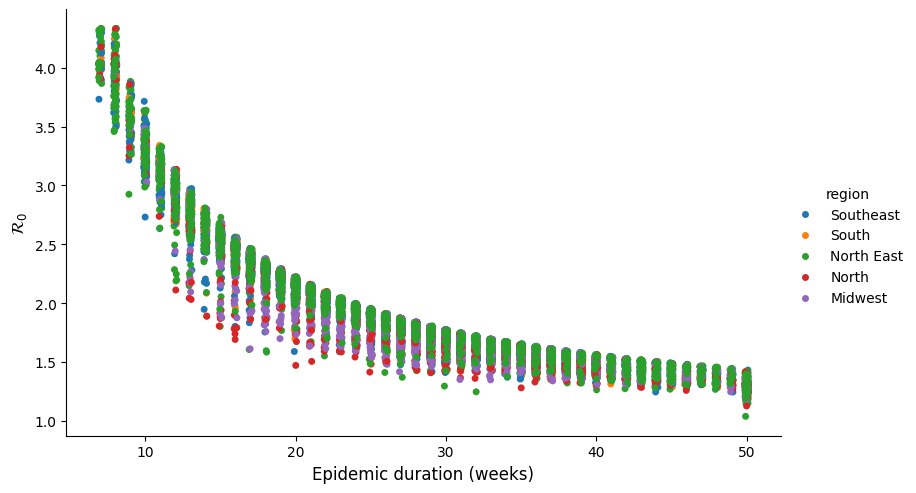

In [17]:
scatter_ep_dur_R0(pars_end)

### Figure 2 map sup

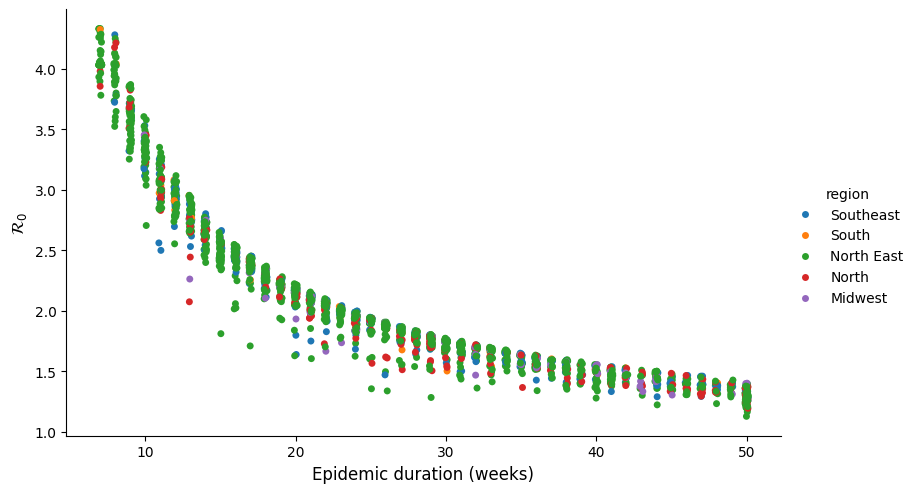

In [18]:
scatter_ep_dur_R0(pars_end_c, agravo = 'chikungunya')

### Figure 9

In [19]:
df_end_br = pd.DataFrame()

for region in ['no', 'sud', 'ne', 'ceo', 'sul']: 

    df =  pd.read_csv(f'data/features_{region}.csv.gz', index_col = 'Unnamed: 0')

    df['region'] = region

    df_end_br = pd.concat([df_end_br, df])

df_end_br.head()

,year,casos_01,casos_1_3,casos_1_4,populacao_1,peak_week_1,R0_1,t_end_1,ep_dur_1,dummy_ep,...,temp_max_1_current,temp_min_1_current,precip_tot_1_current,rainy_day_1_current,enso_1_current,latitude,longitude,peak_week,geocode,region
0,2012,2.639057,3.555348,2.639057,10.159485,12.113873,1.422825,32,31,1,...,29.420512,23.796876,91.433849,3.433987,-1.08,-0.983373,-62.9311,21.323685,1300409,no
1,2021,0.693147,3.871201,1.386294,10.226947,40.000000,1.349717,51,49,1,...,29.505701,24.053100,76.506310,3.433987,-1.20,-0.983373,-62.9311,34.282435,1300409,no
2,2021,4.219508,2.302585,4.219508,10.690467,7.465931,2.199706,16,15,1,...,28.921503,22.922703,124.760211,3.433987,-1.20,-4.377680,-70.0342,11.887917,1300607,no
3,2014,3.178054,4.574711,4.094345,10.547261,37.194264,1.237229,51,50,1,...,30.204493,23.410592,93.780748,3.433987,-0.51,-4.391540,-59.5874,16.680013,1300805,no
4,2015,1.945910,2.890372,1.098612,10.563285,16.680013,1.567545,32,31,1,...,29.524120,22.959199,131.857981,3.433987,0.23,-4.391540,-59.5874,30.169698,1300805,no


In [20]:
df_end_br['region'] = df_end_br['region'].replace({'no': 'Norte', 'ne':'Nordeste', 'ceo':'Centro - Oeste',
                                                  'sud': 'Sudeste', 'sul':'Sul'})

In [21]:
df_end_br['enso'] = pd.NA
df_end_br.loc[df_end_br.enso_4 >0, 'enso'] = 'El Niño'
df_end_br.loc[df_end_br.enso_4 <=0, 'enso'] = 'La Niña'

df_end_br.head()

,year,casos_01,casos_1_3,casos_1_4,populacao_1,peak_week_1,R0_1,t_end_1,ep_dur_1,dummy_ep,...,temp_min_1_current,precip_tot_1_current,rainy_day_1_current,enso_1_current,latitude,longitude,peak_week,geocode,region,enso
0,2012,2.639057,3.555348,2.639057,10.159485,12.113873,1.422825,32,31,1,...,23.796876,91.433849,3.433987,-1.08,-0.983373,-62.9311,21.323685,1300409,Norte,La Niña
1,2021,0.693147,3.871201,1.386294,10.226947,40.000000,1.349717,51,49,1,...,24.053100,76.506310,3.433987,-1.20,-0.983373,-62.9311,34.282435,1300409,Norte,La Niña
2,2021,4.219508,2.302585,4.219508,10.690467,7.465931,2.199706,16,15,1,...,22.922703,124.760211,3.433987,-1.20,-4.377680,-70.0342,11.887917,1300607,Norte,La Niña
3,2014,3.178054,4.574711,4.094345,10.547261,37.194264,1.237229,51,50,1,...,23.410592,93.780748,3.433987,-0.51,-4.391540,-59.5874,16.680013,1300805,Norte,La Niña
4,2015,1.945910,2.890372,1.098612,10.563285,16.680013,1.567545,32,31,1,...,22.959199,131.857981,3.433987,0.23,-4.391540,-59.5874,30.169698,1300805,Norte,El Niño


/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_24691/3541881975.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_end_br[df_end_br['region'] == 'Sul'], x='enso', y='peak_week', ax=ax1, palette=['tab:blue', 'tab:red'], showfliers = False)
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_24691/3541881975.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_end_br[df_end_br['region'] == 'Sudeste'], x='enso', y='peak_week', ax=ax2, palette=['tab:blue', 'tab:red'],  showfliers = False)
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_24691/3541881975.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be rem

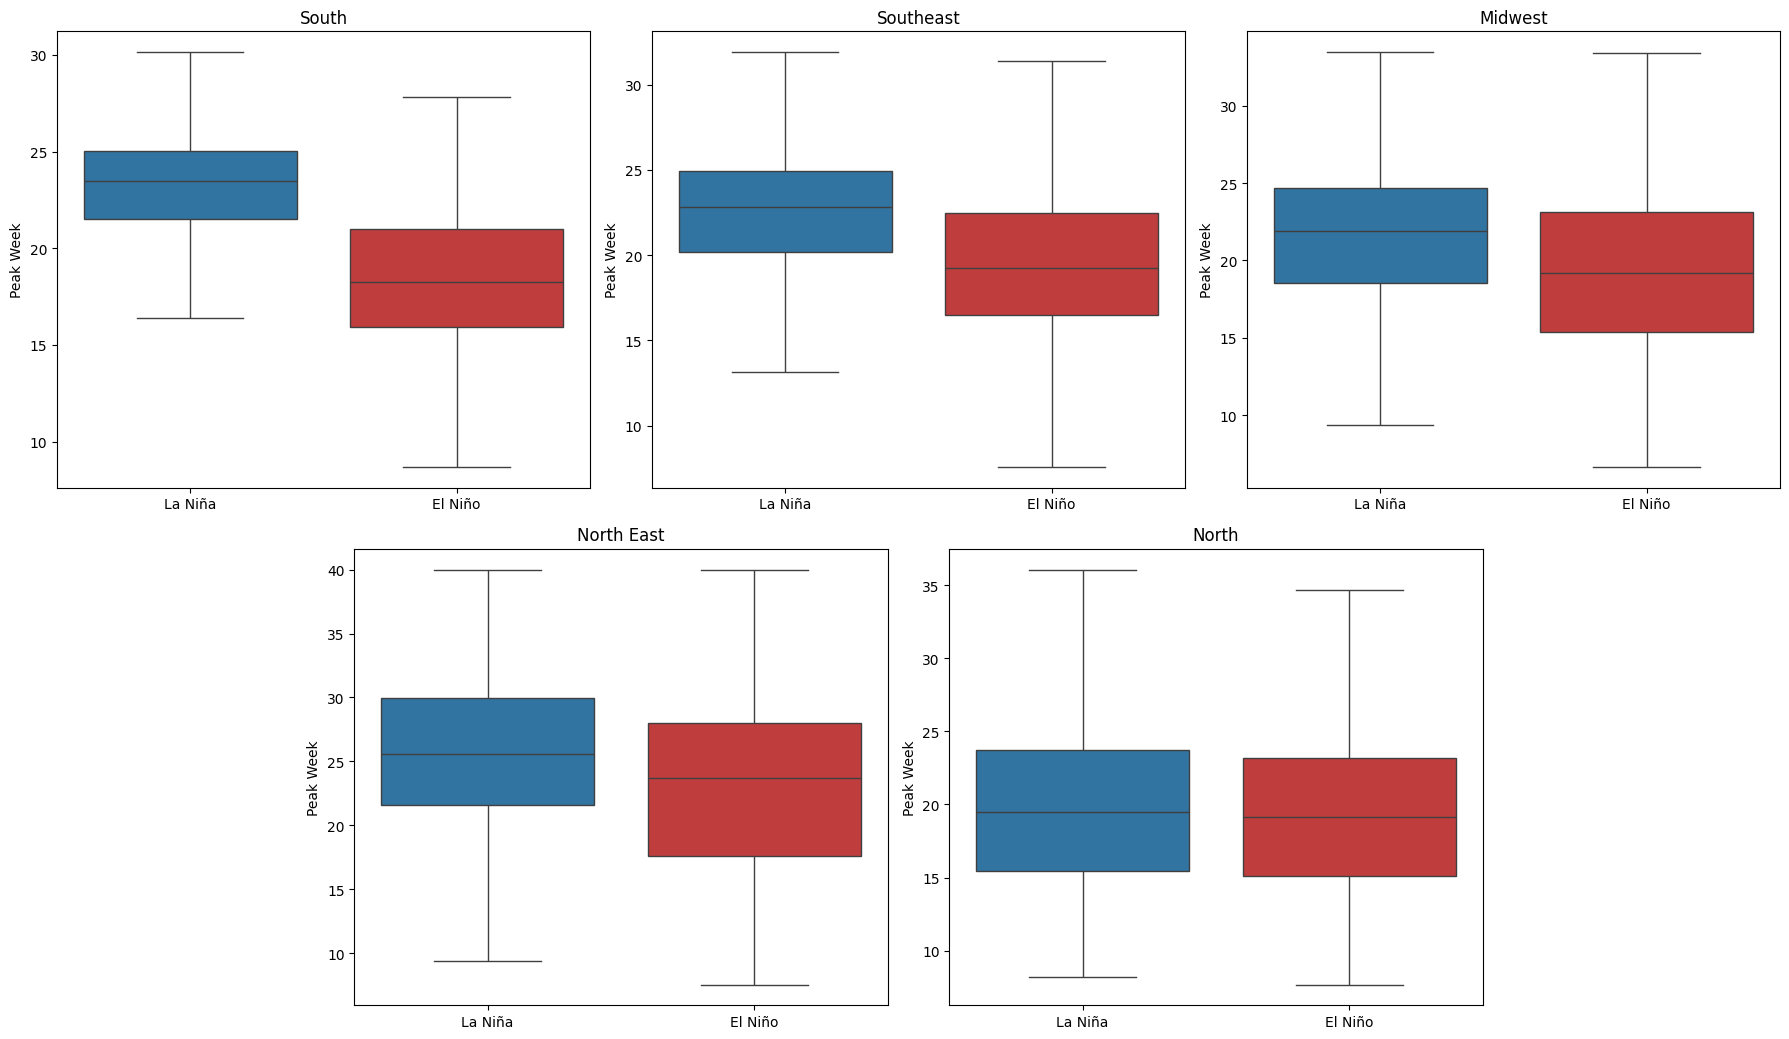

In [22]:
sns.set_context(font_scale=1.2)

fig = plt.figure(figsize=(18, 10.5))
gs = gridspec.GridSpec(2, 6, figure=fig)

# First row with three boxplots
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])

# Second row with two boxplots
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])

# Plot the boxplots
sns.boxplot(data=df_end_br[df_end_br['region'] == 'Sul'], x='enso', y='peak_week', ax=ax1, palette=['tab:blue', 'tab:red'], showfliers = False)
ax1.set_title('South')
ax1.set_ylabel('Peak Week')
ax1.set_xlabel('')

sns.boxplot(data=df_end_br[df_end_br['region'] == 'Sudeste'], x='enso', y='peak_week', ax=ax2, palette=['tab:blue', 'tab:red'],  showfliers = False)
ax2.set_title('Southeast')
ax2.set_ylabel('Peak Week')
ax2.set_xlabel('')

sns.boxplot(data=df_end_br[df_end_br['region'] == 'Centro - Oeste'], x='enso', y='peak_week', ax=ax3, palette=['tab:blue', 'tab:red'],  showfliers = False)
ax3.set_title('Midwest')
ax3.set_ylabel('Peak Week')
ax3.set_xlabel('')

# If there are additional categories
sns.boxplot(data=df_end_br[df_end_br['region'] == 'Nordeste'], x='enso', y='peak_week', ax=ax4, palette=['tab:blue', 'tab:red'],  showfliers = False)
ax4.set_title('North East')
ax4.set_ylabel('Peak Week')
ax4.set_xlabel('')

sns.boxplot(data=df_end_br[df_end_br['region'] == 'Norte'], x='enso', y='peak_week', ax=ax5, palette=['tab:blue', 'tab:red'], showfliers = False )
ax5.set_title('North')
ax5.set_ylabel('Peak Week')
ax5.set_xlabel('')

# Adjust layout
plt.tight_layout()

#ig.suptitle('Peak week - Dengue', y = 1.02, fontsize=16)
plt.savefig('./figures/box_pw_regions.png', dpi = 600, bbox_inches = 'tight')
plt.show()